In [12]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize

In [53]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_name = '2017_11_30_11_49_33_uw-rfe-short-op'
exp_date = '_'.join(exp_name.split('_')[:3])
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
cuts = [[22],[3]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
q.set_thresholds(cuts)

name 'fort_exp' is not defined


In [54]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

In [55]:
retention = q.apply_thresholds()

In [56]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.00	retention:0.953 +- 0.014
ivar:	0.02	retention:0.755 +- 0.029
ivar:	0.04	retention:0.553 +- 0.034
ivar:	0.06	retention:0.238 +- 0.029
ivar:	0.08	retention:0.113 +- 0.022
ivar:	0.10	retention:0.252 +- 0.030
ivar:	0.12	retention:0.483 +- 0.034
ivar:	0.14	retention:0.788 +- 0.028
ivar:	0.16	retention:0.940 +- 0.016
ivar:	0.18	retention:0.815 +- 0.027
ivar:	0.19	retention:0.513 +- 0.034
ivar:	0.21	retention:0.220 +- 0.028


In [57]:
q.save_experiment_data()

In [58]:
def rfe(x, a, f, phi, b):
    return b + a*np.cos(2*np.pi*f*x+phi)

<IPython.core.display.Javascript object>


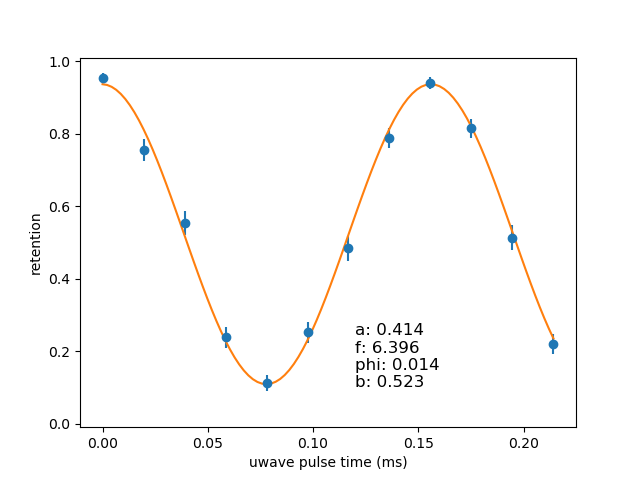

[ 0.4138927   6.39628778  0.01357092  0.52269421]


In [61]:
fig, ax = plt.subplots()
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(xlab)

guess = [0.1, 6.7, 0, 0.8]
for e in range(len(retention['ivar'])):
    popt, pcov = optimize.curve_fit(
        rfe,
        retention['ivar'][e],
        retention['retention'][e],
        p0=guess,
        sigma=retention['error'][e]
    )
    xs = np.linspace(min(retention['ivar'][e]),max(retention['ivar'][e]),100)
    ax.plot(xs, rfe(xs, *popt))
    fit_data = "a: {:.3f}\nf: {:.3f}\nphi: {:.3f}\nb: {:.3f}"
    ax.text(0.12, 0.1, fit_data.format(*popt), fontsize=12)

ax.set_ylabel('retention')
print(popt)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'rfe_retention_fit.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [62]:
0.5/popt[1]

0.078170341476941102

In [65]:
print(popt[3] - popt[0])
print(popt[3] + popt[0])

0.108801511176
0.936586909184
